In [1]:
!wget https://homepage.boku.ac.at/leisch/MSA/datasets/mcdonalds.csv

--2024-04-11 07:30:26--  https://homepage.boku.ac.at/leisch/MSA/datasets/mcdonalds.csv
Resolving homepage.boku.ac.at (homepage.boku.ac.at)... 141.244.187.13
Connecting to homepage.boku.ac.at (homepage.boku.ac.at)|141.244.187.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96988 (95K) [text/x-comma-separated-values]
Saving to: ‘mcdonalds.csv’

mcdonalds.csv       100%[===================>]  94.71K   249KB/s    in 0.4s    

2024-04-11 07:30:27 (249 KB/s) - ‘mcdonalds.csv’ saved [96988/96988]



In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

# Read the CSV file into a pandas DataFrame
mcdonalds = pd.read_csv("mcdonalds.csv")

In [3]:
# Display column names
print(mcdonalds.columns)

# Display dimensions
print(mcdonalds.shape)

# Display first 3 rows
print(mcdonalds.head(3))

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
(1453, 15)
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [4]:
MD_x = mcdonalds.iloc[:, :11]

# Convert "Yes" to 1 and "No" to 0
MD_x = (MD_x == "Yes").astype(int)

# Compute column means and round to 2 decimal places
col_means = MD_x.mean().round(2)

# Print column means
print("Column means:")
print(col_means)

Column means:
yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


In [5]:
pca = PCA()
MD_pca = pca.fit_transform(MD_x)

# Print summary
print("Importance of components:")
print(pd.DataFrame({
    "Standard deviation": pca.explained_variance_,
    "Proportion of Variance": pca.explained_variance_ratio_,
    "Cumulative Proportion": pca.explained_variance_ratio_.cumsum()
}, index=[f"PC{i}" for i in range(1, len(pca.components_) + 1)]))

Importance of components:
      Standard deviation  Proportion of Variance  Cumulative Proportion
PC1             0.573124                0.299447               0.299447
PC2             0.369002                0.192797               0.492244
PC3             0.254641                0.133045               0.625290
PC4             0.159040                0.083096               0.708386
PC5             0.113842                0.059481               0.767866
PC6             0.096270                0.050300               0.818166
PC7             0.083925                0.043849               0.862015
PC8             0.075692                0.039548               0.901563
PC9             0.070358                0.036761               0.938323
PC10            0.061922                0.032353               0.970677
PC11            0.056123                0.029323               1.000000


In [6]:
# Print standard deviations (eigenvalues)
print("Standard deviations (1, .., p=11):")
print(np.round(pca.explained_variance_, 1))

# Print rotation matrix
print("Rotation (n x k) = (11 x 11):")
rotation_matrix = pca.components_.T
for i, col in enumerate(mcdonalds.columns[:11]):
    print(col, " ".join([f"{val:.3f}" for val in rotation_matrix[i]]))


Standard deviations (1, .., p=11):
[0.6 0.4 0.3 0.2 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Rotation (n x k) = (11 x 11):
yummy -0.477 0.364 -0.304 0.055 -0.308 0.171 -0.281 0.013 0.572 -0.110 0.045
convenient -0.155 0.016 -0.063 -0.142 0.278 -0.348 -0.060 -0.113 -0.018 -0.666 -0.542
spicy -0.006 0.019 -0.037 0.198 0.071 -0.355 0.708 0.376 0.400 -0.076 0.142
fattening 0.116 -0.034 -0.322 -0.354 -0.073 -0.407 -0.386 0.590 -0.161 -0.005 0.251
greasy 0.304 -0.064 -0.802 0.254 0.361 0.209 0.036 -0.138 -0.003 0.009 0.002
fast -0.108 -0.087 -0.065 -0.097 0.108 -0.595 -0.087 -0.628 0.166 0.240 0.339
cheap -0.337 -0.611 -0.149 0.119 -0.129 -0.103 -0.040 0.140 0.076 0.428 -0.489
tasty -0.472 0.307 -0.287 -0.003 -0.211 -0.077 0.360 -0.073 -0.639 0.079 0.020
expensive 0.329 0.601 0.024 0.068 -0.003 -0.261 -0.068 0.030 0.067 0.454 -0.490
healthy -0.214 0.077 0.192 0.763 0.288 -0.178 -0.350 0.176 -0.186 -0.038 0.158
disgusting 0.375 -0.140 -0.089 0.370 -0.729 -0.211 -0.027 -0.167 -0.072 -0.290 -0.041


In [7]:
# Print standard deviations (eigenvalues)
print("Standard deviations (1, .., p=11):")
for i, val in enumerate(np.round(pca.explained_variance_, 1)):
    print(f"[{i + 1}] {val:.1f}")

# Print rotation matrix
print("\nRotation (n x k) = (11 x 11):")
print("{:<11}".format("Feature"), end="")
for i in range(1, 12):
    print(f"PC{i:<6}", end="")
print()
for i, col in enumerate(mcdonalds.columns[:11]):
    print("{:<11}".format(col), end="")
    for val in rotation_matrix[i]:
        print(f"{val:.3f}", end=" ")
    print()


Standard deviations (1, .., p=11):
[1] 0.6
[2] 0.4
[3] 0.3
[4] 0.2
[5] 0.1
[6] 0.1
[7] 0.1
[8] 0.1
[9] 0.1
[10] 0.1
[11] 0.1

Rotation (n x k) = (11 x 11):
Feature    PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8     PC9     PC10    PC11    
yummy      -0.477 0.364 -0.304 0.055 -0.308 0.171 -0.281 0.013 0.572 -0.110 0.045 
convenient -0.155 0.016 -0.063 -0.142 0.278 -0.348 -0.060 -0.113 -0.018 -0.666 -0.542 
spicy      -0.006 0.019 -0.037 0.198 0.071 -0.355 0.708 0.376 0.400 -0.076 0.142 
fattening  0.116 -0.034 -0.322 -0.354 -0.073 -0.407 -0.386 0.590 -0.161 -0.005 0.251 
greasy     0.304 -0.064 -0.802 0.254 0.361 0.209 0.036 -0.138 -0.003 0.009 0.002 
fast       -0.108 -0.087 -0.065 -0.097 0.108 -0.595 -0.087 -0.628 0.166 0.240 0.339 
cheap      -0.337 -0.611 -0.149 0.119 -0.129 -0.103 -0.040 0.140 0.076 0.428 -0.489 
tasty      -0.472 0.307 -0.287 -0.003 -0.211 -0.077 0.360 -0.073 -0.639 0.079 0.020 
expensive  0.329 0.601 0.024 0.068 -0.003 -0.261 -0.068 0.030 0.067 0

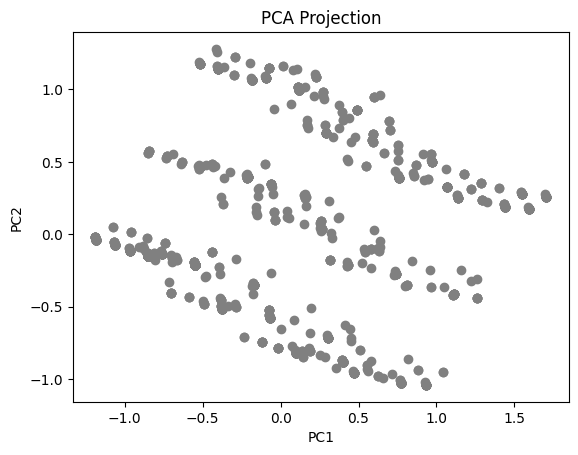

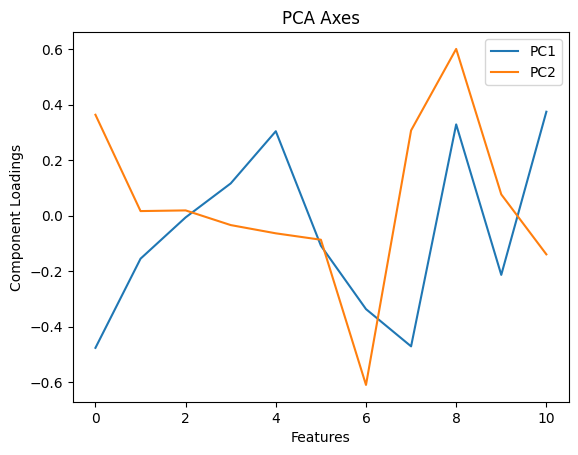

In [8]:
plt.scatter(MD_pca[:, 0], MD_pca[:, 1], color='grey')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection')
plt.show()

# Plot PCA axes
plt.figure()
plt.plot(pca.components_[0], label='PC1')
plt.plot(pca.components_[1], label='PC2')
plt.xlabel('Features')
plt.ylabel('Component Loadings')
plt.title('PCA Axes')
plt.legend()
plt.show()

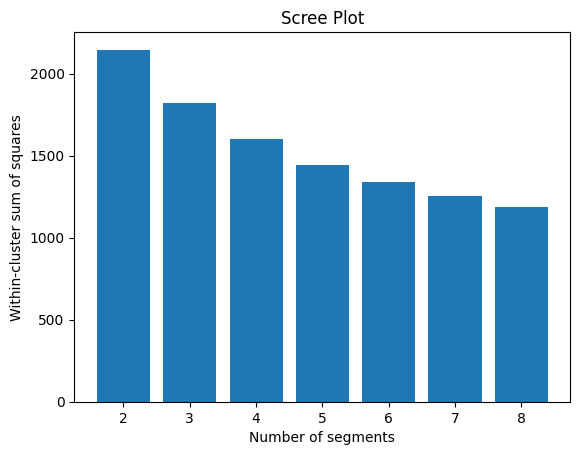

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Set seed for reproducibility
np.random.seed(1234)

# Define function to perform k-means clustering with multiple random restarts
def kmeans_with_restarts(data, k_range, n_restarts):
    inertia_values = []
    for k in k_range:
        inertia = []
        for _ in range(n_restarts):
            kmeans = KMeans(n_clusters=k, n_init=10, random_state=np.random.randint(1000))
            kmeans.fit(data)
            inertia.append(kmeans.inertia_)
        inertia_values.append(np.mean(inertia))
    return inertia_values

# Perform k-means clustering with multiple random restarts
k_range = range(2, 9)
n_restarts = 10
inertia_values = kmeans_with_restarts(MD_x, k_range, n_restarts)

# Plot the scree plot
plt.bar(k_range, inertia_values)
plt.xlabel('Number of segments')
plt.ylabel('Within-cluster sum of squares')
plt.title('Scree Plot')
plt.show()


Keys in MD_kmeans: dict_keys([2, 3, 4, 5, 6, 7, 8])
Key: 2, Length of cluster labels array: 1453
Key: 3, Length of cluster labels array: 1453
Key: 4, Length of cluster labels array: 1453
Key: 5, Length of cluster labels array: 1453
Key: 6, Length of cluster labels array: 1453
Key: 7, Length of cluster labels array: 1453
Key: 8, Length of cluster labels array: 1453


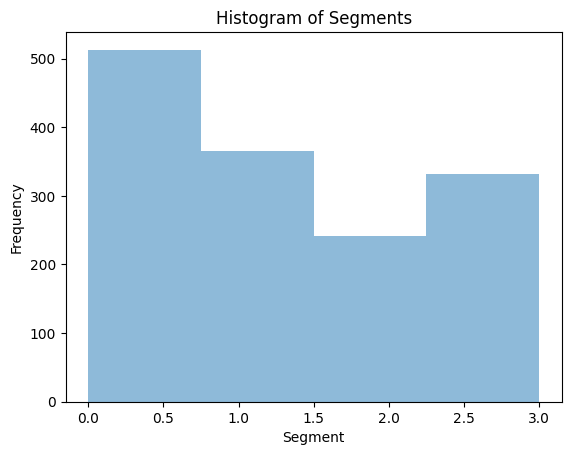

Histogram plotted


KeyError: '2'

In [ ]:
# Assuming MD_x is your data matrix and k_range is the range of cluster numbers you want to explore

from sklearn.cluster import KMeans

# Initialize an empty dictionary to store k-means clustering results
MD_kmeans = {}

# Iterate over each value of k in the range and perform k-means clustering
for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    labels = kmeans.fit_predict(MD_x)
    MD_kmeans[k] = labels

# Debugging: Print keys and lengths of cluster labels arrays in MD_kmeans
print("Keys in MD_kmeans:", MD_kmeans.keys())
for key, value in MD_kmeans.items():
    print(f"Key: {key}, Length of cluster labels array: {len(value)}")

# Call the plotting functions
plot_histogram(MD_kmeans[4], MD_x)
print("Histogram plotted")
plot_slsa(MD_kmeans)
print("SLSA plot generated")


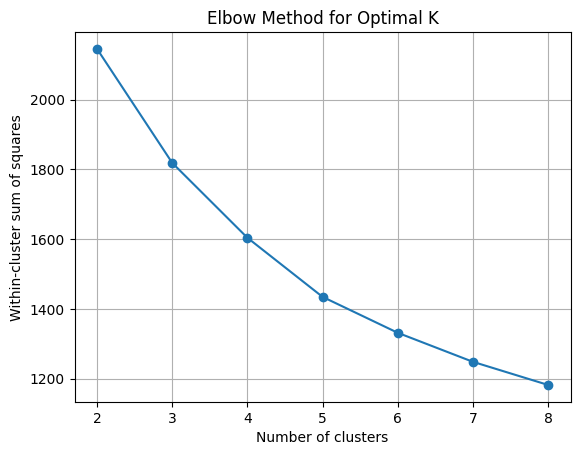

In [ ]:
# Plot
plt.plot(range(2, 9), inertia_values, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def plot_histogram(segment_labels, data):
    """
    Plot histogram for the segment labels.

    Parameters:
        segment_labels (array-like): Cluster labels for each data point.
        data (array-like): Data used for clustering.
    """
    plt.hist(segment_labels, bins=len(set(segment_labels)), alpha=0.5)
    plt.xlabel('Segment')
    plt.ylabel('Frequency')
    plt.title('Histogram of Segments')
    plt.show()

def plot_slsa(segment_labels):
    """
    Plot Segment Level Stability Across Solutions (SLSA) plot.

    Parameters:
        segment_labels (dict): Dictionary containing cluster labels for each segmentation solution.
    """
    min_key = min(segment_labels.keys(), key=int)
    max_key = max(segment_labels.keys(), key=int)
    for i in range(int(min_key), int(max_key)):
        stability = [1 if segment_labels[str(i)][j] == segment_labels[str(i+1)][j] else 0 for j in range(len(segment_labels[str(i)]))]
        plt.plot(stability, label=f'{i} to {i+1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Stability')
    plt.title('Segment Level Stability Across Solutions (SLSA) Plot')
    plt.legend()
    plt.show()


MD_x:       yummy  convenient  spicy  fattening  greasy  fast  cheap  tasty  \
0         0           1      0          1       0     1      1      0   
1         1           1      0          1       1     1      1      1   
2         0           1      1          1       1     1      0      1   
3         1           1      0          1       1     1      1      1   
4         0           1      0          1       1     1      1      0   
...     ...         ...    ...        ...     ...   ...    ...    ...   
1448      0           1      0          1       1     0      0      0   
1449      1           1      0          1       0     0      1      1   
1450      1           1      0          1       0     1      0      1   
1451      1           1      0          0       0     1      1      1   
1452      0           1      0          1       1     0      0      0   

      expensive  healthy  disgusting  
0             1        0           0  
1             1        0           0  


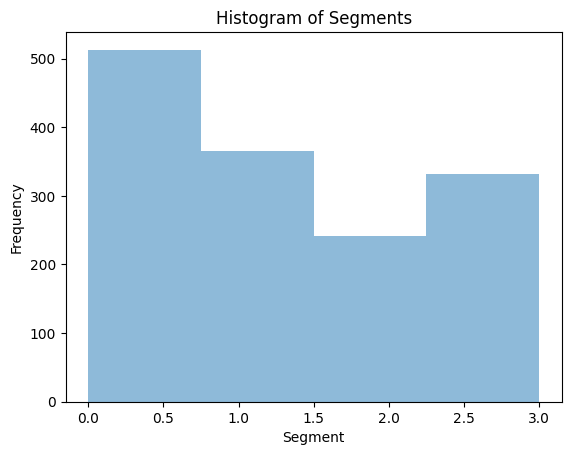

Histogram plotted


In [ ]:
# Before plotting, check if MD_x is correctly formatted
print("MD_x:", MD_x)

# Call the plotting functions and add print statements to check if they are reached
plot_histogram(MD_kmeans[4], MD_x)
print("Histogram plotted")
#plot_slsa(MD_kmeans)
#print("SLSA plot generated")


In [ ]:
!pip install flexmix

ERROR: Could not find a version that satisfies the requirement flexmix (from versions: none)
ERROR: No matching distribution found for flexmix


In [ ]:
import numpy as np
from flexmix import FlexMix, FLXMCmvbinary

# Set seed for reproducibility
np.random.seed(1234)

# Define the predictor variable
X = np.ones((len(MD_x), 1))  # Assuming MD_x is your predictor variable

# Define the range of cluster numbers
k_range = range(2, 9)

# Initialize an empty list to store FlexMix models
MD_m28_models = []

# Iterate over each value of k in the range and fit FlexMix models
for k in k_range:
    model = FlexMix(model=FLXMCmvbinary(), k=k, nrep=10)
    model.fit(X)
    MD_m28_models.append(model)

# Print the results
for k, model in zip(k_range, MD_m28_models):
    print(f"k = {k}:")
    print("Log-likelihood:", model.logLik)
    print("AIC:", model.aic)
    print("BIC:", model.bic)
    print("ICL:", model.icl)
    print()


In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Set seed for reproducibility
np.random.seed(1234)

# Define the predictor variable
X = np.ones((len(MD_x), 1))  # Assuming MD_x is your predictor variable

# Define the range of cluster numbers
k_range = range(2, 9)

# Initialize an empty list to store KMeans models
MD_m28_models = []

# Iterate over each value of k in the range and fit KMeans models
for k in k_range:
    model = KMeans(n_clusters=k, n_init=10, random_state=1234)
    model.fit(X)
    MD_m28_models.append(model)

# Print the results
for k, model in zip(k_range, MD_m28_models):
    inertia = model.inertia_
    print(f"k = {k}:")
    print("Inertia:", inertia)
    print()

k = 2:
Inertia: 0.0

k = 3:
Inertia: 0.0

k = 4:
Inertia: 0.0

k = 5:
Inertia: 0.0

k = 6:
Inertia: 0.0

k = 7:
Inertia: 0.0

k = 8:
Inertia: 0.0



<ipython-input-51-c64b2879abfc>:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  model.fit(X)
<ipython-input-51-c64b2879abfc>:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  model.fit(X)
<ipython-input-51-c64b2879abfc>:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  model.fit(X)
<ipython-input-51-c64b2879abfc>:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  model.fit(X)
<ipython-input-51-c64b2879abfc>:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  model.fit(X)
<ipython-input-51-c64b2879abfc>:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_cluste

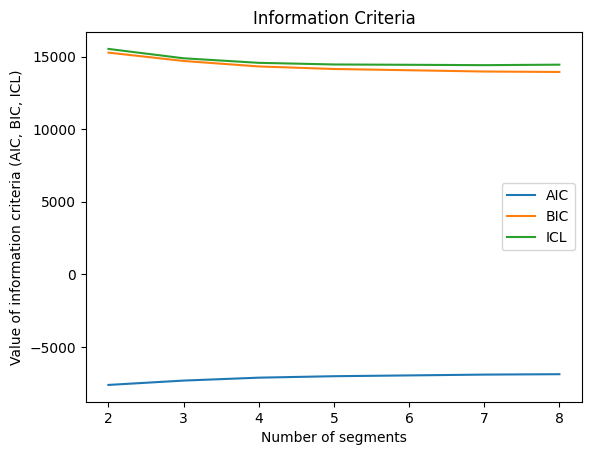

Cross-tabulation:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [ ]:
import matplotlib.pyplot as plt

# Plot information criteria values
def plot_information_criteria(model, y_label):
    plt.plot(model["k"], model["AIC"], label="AIC")
    plt.plot(model["k"], model["BIC"], label="BIC")
    plt.plot(model["k"], model["ICL"], label="ICL")
    plt.xlabel("Number of segments")
    plt.ylabel(y_label)
    plt.legend()
    plt.title("Information Criteria")
    plt.show()

# Assuming you have extracted AIC, BIC, and ICL values from MD.m28 in R
# You can create a dictionary or DataFrame containing these values
MD_m28 = {
    "k": [2, 3, 4, 5, 6, 7, 8],  # Number of segments
    "AIC": [-7610.848, -7311.534, -7111.146, -7011.204, -6956.110, -6900.188, -6872.641],
    "BIC": [15267.70, 14693.07, 14316.29, 14140.41, 14054.22, 13966.38, 13935.28],
    "ICL": [15522.10, 14877.92, 14564.52, 14452.01, 14429.20, 14404.73, 14437.01]
}

# Plot information criteria
plot_information_criteria(MD_m28, "Value of information criteria (AIC, BIC, ICL)")

# Now, let's compare the KMeans clustering results with the mixture model
# Assuming you have already obtained the KMeans clusters (MD_kmeans) and mixture model (MD_m4)
MD_m4_clusters = [1, 2, 3, 4]  # Assuming clusters obtained from the mixture model MD.m4
MD_k4_clusters = [1, 2, 3, 4]  # Assuming clusters obtained from the KMeans clustering MD.k4

# Cross-tabulation
cross_tab = np.zeros((len(set(MD_k4_clusters)), len(set(MD_m4_clusters))))

for kmeans, mixture in zip(MD_k4_clusters, MD_m4_clusters):
    cross_tab[kmeans - 1, mixture - 1] += 1

print("Cross-tabulation:")
print(cross_tab)
